<a href="https://colab.research.google.com/github/jptrujillo/Spraak_en_Gebarenherkenning_materials/blob/main/Emotion_Recognition_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
uwrfkaggler_ravdess_emotional_speech_audio_path = kagglehub.dataset_download('uwrfkaggler/ravdess-emotional-speech-audio')
ejlok1_toronto_emotional_speech_set_tess_path = kagglehub.dataset_download('ejlok1/toronto-emotional-speech-set-tess')
ejlok1_cremad_path = kagglehub.dataset_download('ejlok1/cremad')
ejlok1_surrey_audiovisual_expressed_emotion_savee_path = kagglehub.dataset_download('ejlok1/surrey-audiovisual-expressed-emotion-savee')


print('Data source import complete.')

!pip install keras.import.


Using Colab cache for faster access to the 'ravdess-emotional-speech-audio' dataset.
Using Colab cache for faster access to the 'toronto-emotional-speech-set-tess' dataset.


100%|██████████| 451M/451M [00:15<00:00, 29.6MB/s]

Extracting files...


100%|██████████| 107M/107M [00:04<00:00, 23.5MB/s]

Extracting files...


Data source import complete.


#<center>Building an Audio Emotion classifier</center>

## Week 2: Spraak- en Gebarenherkenning 2026
---


# Introduction
NOTE: this tutorial is heavily based on a [series of notebooks by Eu Jin Lok](https://www.kaggle.com/code/ejlok1/audio-emotion-part-1-explore-data), who was generous enough to make these resources available.<br>
We are going to build an audio emotion classifier. But why you ask, are we doing this? Well, for a few reasons:

- **Accessibility**<br/>
One reason is that it's one of the more accesible **labeled** datasets. Don't misunderstand, there are many good quality audio datasets out there, but many are either not relevant (eg. background noises), or locked behind paid wall. Emotions are also general enough (not context dependent), so we can apply to a vast number of different projects

The ultimate end game is to get the best accuracy that will generalise across unseen data. Right now its unclear how we mix and match (or excluded) our datasets so that's why we need to explore it first. So lets begin

### Contents
* Part 1 | Data Exploration
* Part 2 | Feature Extract
* Part 3 | Baseline model
* Part 4 | Apply to new audio data

In [ ]:
# Import libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

The 4 sources of the datasets are all on Kaggle so I've just imported them into the workspace. The directory path to the 4 sources in this environment are below:

In [ ]:
TESS = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
RAV = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
CREMA = "/kaggle/input/cremad/AudioWAV/"


# Run one example
dir_list = os.listdir(RAV)
dir_list[0:5]

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21']

<a id="ravdess"></a>
## <center>1. RAVDESS dataset</center>

RAVDESS is one of the more common dataset used for this excercise by others. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders. And there's more! You can get it in song format as well. There's something for everyone and their research project. So for convenience, here's the filename identifiers as per the official RAVDESS website:

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename.
_02-01-06-01-02-01-12.mp4_

This means the meta data for the audio file is:
- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement "dogs" (02)
- 1st Repetition (01)
- 12th Actor (12) - Female (as the actor ID number is even)

At my early beginings embarking on this journey, I learnt through the hard way that male and female speakers have to be trained seperately or the model will struggle to get a good accuracy. From reading a few blogs and articles, it seems female has a higher pitch that male. So if we don't tag the gender label to the audio file, it won't be able to detect anger or fear if it was a male speaker. It will just get bucketed into neutral

Lets specifically model the 2 speakers seperately. Note that there's a 'calm' emotion and a 'neutral' emotion as seperate. I don't really know the difference but for now, I'll just combined them into the same category.

<a id="ravdess_load"></a>
###  Load the dataset
Because of the way the entire data was packaged for us, and the format of the audio filename, there's a few more parsing steps required for the RAVDESS dataset compared to SAVEE

In [ ]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)


RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

labels
male_neutral       144
female_neutral     144
male_fear           96
male_happy          96
male_disgust        96
male_sad            96
male_angry          96
male_surprise       96
female_surprise     96
female_disgust      96
female_fear         96
female_sad          96
female_happy        96
female_angry        96
Name: count, dtype: int64

<a id="ravdess_explore"></a>
### Explore the data
Lets do the same thing again, take 2 audio files, play it and plot it to see what we're dealing with. And how different they are to SAVEE as we go along. Lets start with a fearful track

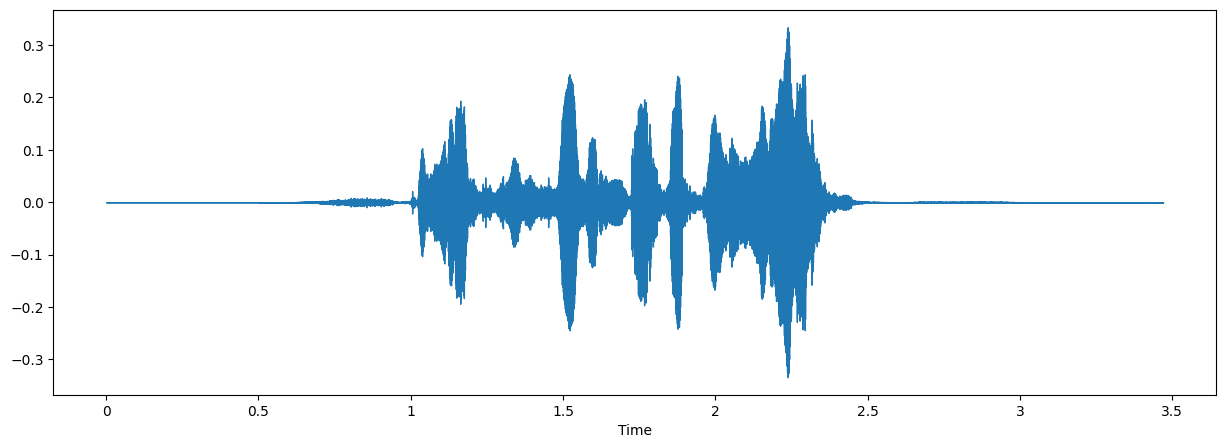

In [ ]:
# Pick a fearful track
fname = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio
ipd.Audio(fname)

Excellent audio quality. And well acted out. I think you can genuinely feel the fear from the speaker. I do notice that there's a lot of silence between the start and end. We'll address it later in later parts. Lets play another random file, maybe a happy one this time.

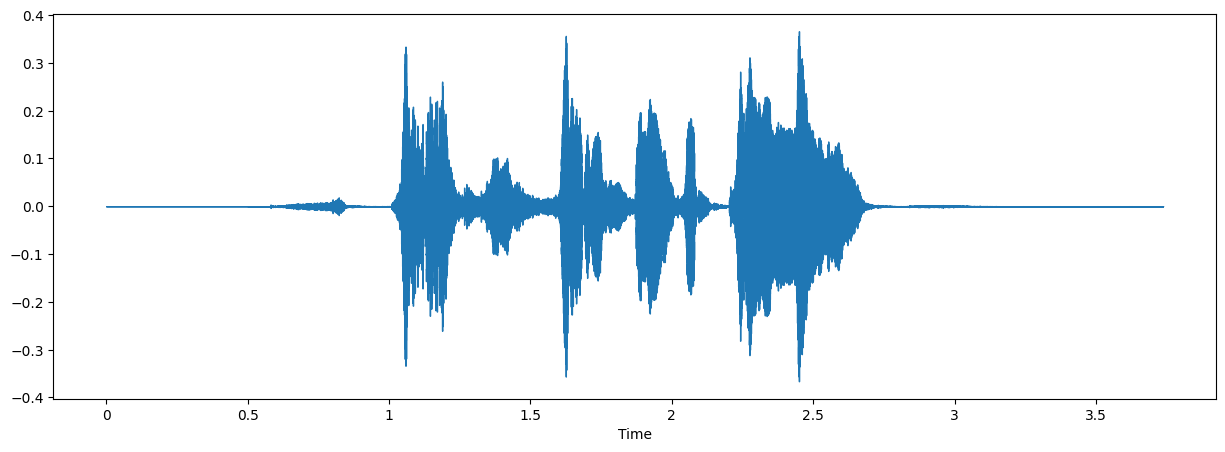

In [ ]:
# Pick a happy track
fname = RAV + 'Actor_14/03-01-03-02-02-02-14.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio
ipd.Audio(fname)

<a id="ravdess_con"></a>
### Conclusion
...ok, to be fairly honest, I actual felt like that was a fearful tone at the start, up until the end. I had to play it 3 or 4 times to finally be convienced that it is indeed a happy sound. Looking at the wave plot between the 2 files, I notice the only real difference is the amplitute wherein this happy track has a higher amplituted at various points. But, could be coincidence, who knows at this stage.

What I do know is that the audio quality is good and we need females in the dataset. If we don't include females, we'll end up with an AI that is bias towards / aagainst one gender, and its unethical. Unless there's a good reason, I'm not taking it out.  

<a id="final"></a>
##  <center> 5. Final thoughts<center>
All 4 dataset are good datasets. Having listen to them and doing some really rough inspections, I feel we can combine all of them. We need to anyway or else we will run into problems with overfitting. One of the issues that I see many other people before me who have made an attempt on an emotion classifier, they tend to stick to just one dataset. And whilst their hold-out set accuracy is high, they don't work well on new unseen dataset.
    
This is because, the classifier is trained on the same dataset and given the similar circumstances that the dataset was obtained or produced, (eg. audio quality, speaker repetition, duration and sentence uttered). To enable it to do well on new datasets, it needs to be given noise, make it work hard to find the real distinguishing characteristics of the emotion.

Before we end it, final steps are to combine all the meta-data together as one. Remember we saved the paths for all the audio files. So this will be handy when we need to read all 4 data sources in different folder structures.

Upvote this notebook if you like, and be sure to check out the other parts which are now available:
* [Part 2 | Feature Extract](https://www.kaggle.com/ejlok1/audio-emotion-part-2-feature-extract)
* [Part 3 | Baseline model](https://www.kaggle.com/ejlok1/audio-emotion-part-3-baseline-model)
* [Part 4 | Apply to new audio data](https://www.kaggle.com/ejlok1/audio-emotion-part-4-apply-to-new-audio-data)

In [ ]:
df = RAV_df
print(df.labels.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

labels
male_neutral       144
female_neutral     144
male_fear           96
male_happy          96
male_disgust        96
male_sad            96
male_angry          96
male_surprise       96
female_surprise     96
female_disgust      96
female_fear         96
female_sad          96
female_happy        96
female_angry        96
Name: count, dtype: int64


# <center>Audio Emotion Recognition</center>
## <center>Part 2 - Feature Extraction </center>
#### <center> 21st August 2019 </center>
#####  <center> Eu Jin Lok </center>

## Introduction
Following on from [Part 1](https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-1-explore-data), we are now going to check out the various techniques for extracting useful features from audio for our classifier. I've done this before in another different kernel over [here](https://www.kaggle.com/ejlok1/part-2-extracting-audio-features/notebook#Part-2---Extracting-Audio-Features). I haven't covered the entireity of the various audio features, just ones which I'm familiar with. Any suggestions or advice please drop me a note. For a more complete coverage of the various features, I suggest checking the [pyaudio journal](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0144610&type=printable)

Broadly speaking there are two category of features:
- Time domain features<br/>
These are simpler to extract and understand, like the energy of signal, zero crossing rate, maximum amplitude, minimum energy, etc.
- Frequency based features<br/>
are obtained by converting the time based signal into the frequency domain. Whilst they are harder to comprehend, it provides extra information that can be really handy such as pitch, rhythms, melody etc. Check this infographic below:

![Audio_wave](https://www.nti-audio.com/portals/0/pic/news/FFT-Time-Frequency-View-540.png)
The time vs frequency domain image sourced from __[here](https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft)__



Since I've already outlined the various types of features [here](https://www.kaggle.com/ejlok1/part-2-extracting-audio-features/notebook#Part-2---Extracting-Audio-Features), I'll just simplify things here and just use MFCC, because we're trying to get to a quick working baseline. Later on, during the accuracy improvement phase, we may expand our feature set to include Mel-Spectogram, Chroma, HPSS and etc... and not just a simple mean

1. [MFCC quick intro](#mfcc)
2. [Deepdive](#deep)
3. [Statistical features](#stats)
4. [Final thoughts](#final)

Upvote this notebook if you like, and be sure to check out the other parts which are now available:
* [Part 3 | Baseline model](https://www.kaggle.com/ejlok1/audio-emotion-part-3-baseline-model)
* [Part 4 | Apply to new audio data](https://www.kaggle.com/ejlok1/audio-emotion-part-4-apply-to-new-audio-data)
* [Part 5 | Data augmentation](https://www.kaggle.com/ejlok1/audio-emotion-part-5-data-augmentation)

Most importantly, I want to thank the 4 authors for their excellent dataset, without it, writing this notebook could not have been possible. The original source of the dataset links are below:

- [TESS](https://tspace.library.utoronto.ca/handle/1807/24487)
- [CREMA-D](https://github.com/CheyneyComputerScience/CREMA-D)
- [SAVEE](http://kahlan.eps.surrey.ac.uk/savee/Database.html)
- [RAVDESS](https://zenodo.org/record/1188976#.XYP8CSgzaUk)
- [RAVDESS_Kaggle](https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio)

<a id="mfcc"></a>
## 1. MFCC quick intro
MFCC is well known to be a good feature. And there's many ways you can slice and dice this one feature. But what is MFCC? It stands for Mel-frequency cepstral coefficient, and it is a good "representation" of the vocal tract that produces the sound. Think of it like an x-ray of your mouth

This post has a good deep dive into the [MFCC](https://medium.com/prathena/the-dummys-guide-to-mfcc-aceab2450fd) should you wish to. The most common machine learning application treats the MFCC itself as an 'image' and becomes a feature. The benefit of treating it as an image is that it provides more information, and gives one the ability to draw on transfer learning. This is certainly legit and yields good accuracy. However, research has also shown that statistics relating to MFCCs (or any other time or frequency domain) can carry good amount of information as well. We'll be investigating both of this methods

In [ ]:
# Import our libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import pandas as pd
import os
import IPython.display as ipd  # To play sound in the notebook

<a id="deep"></a>
## 2. Deepdive
We can select a few examples and visualise the MFCC. lets take 2 different emotions and 2 different genders, and play it just to get a feel for what we are dealing with. Ie. whether the data (audio) quality is good. It gives us an early insight as to how likely our classifier is going to be successful.   

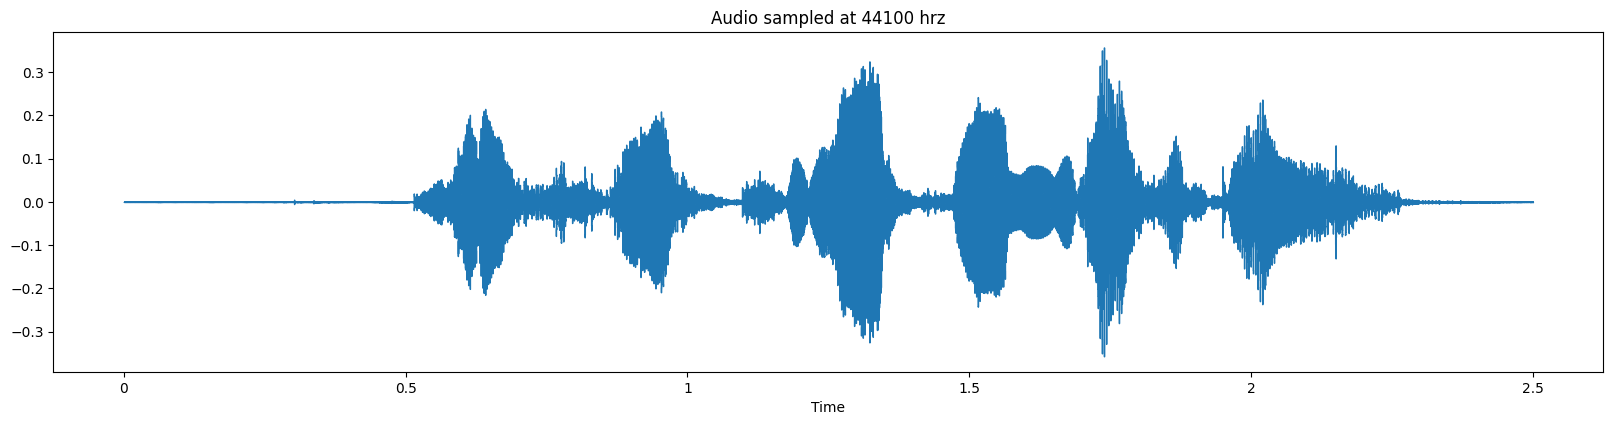

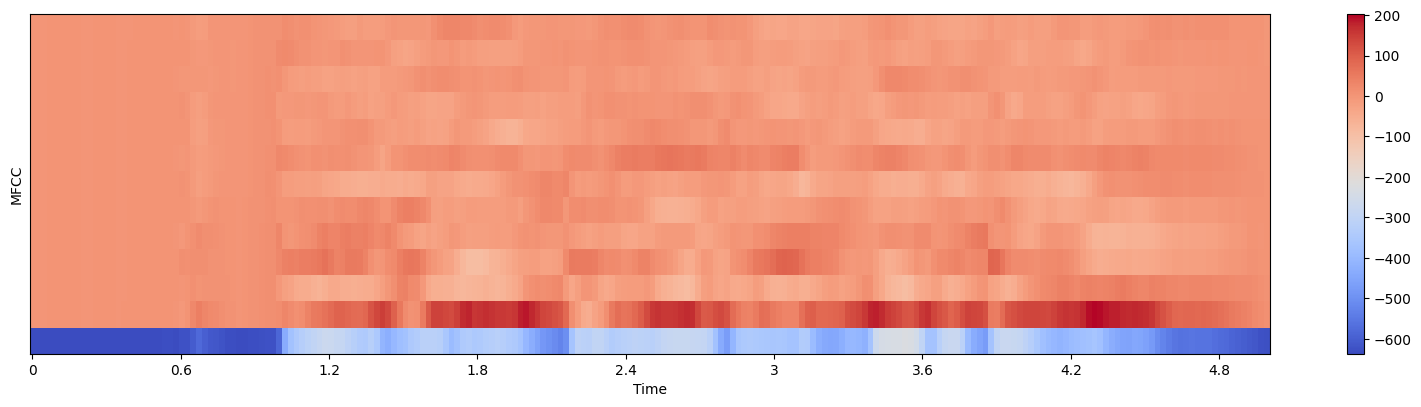

In [ ]:
# Source - RAVDESS; Gender - Female; Emotion - Angry
import resampy
path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path,duration=2.5,sr=22050*2,offset=0.5)
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

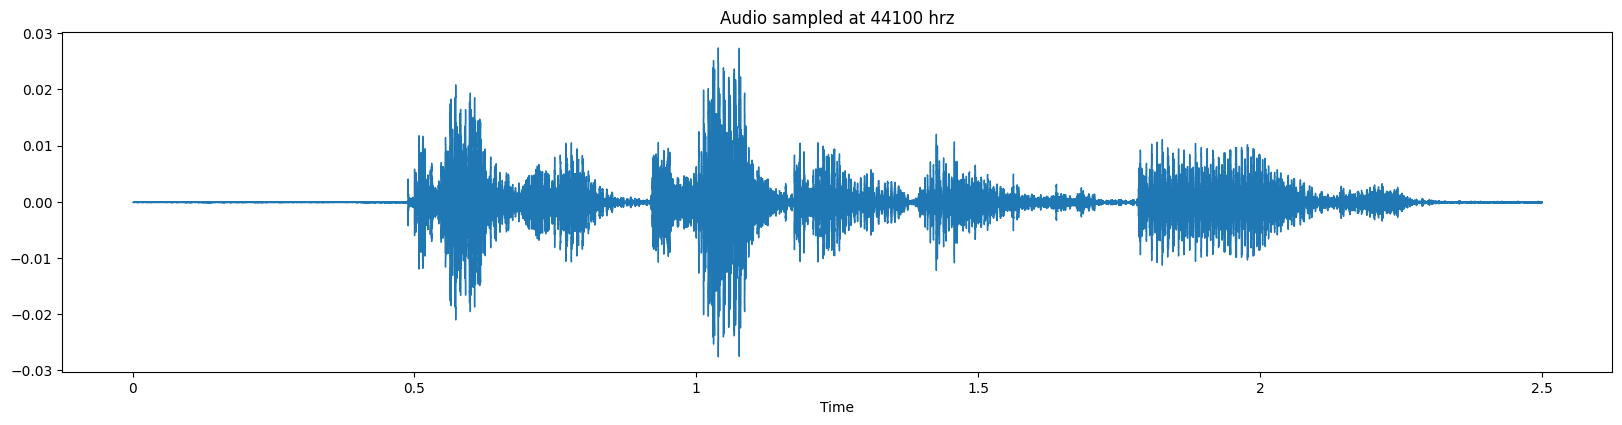

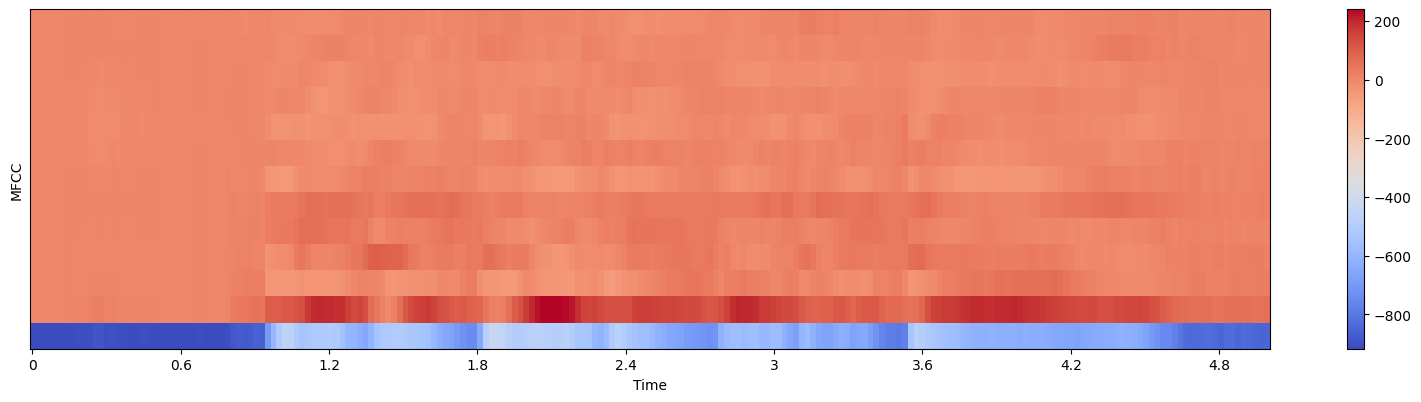

In [ ]:
# Source - RAVDESS; Gender - Male; Emotion - Angry
path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, duration=2.5,sr=22050*2,offset=0.5)
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

Very placid response from the male counter part...

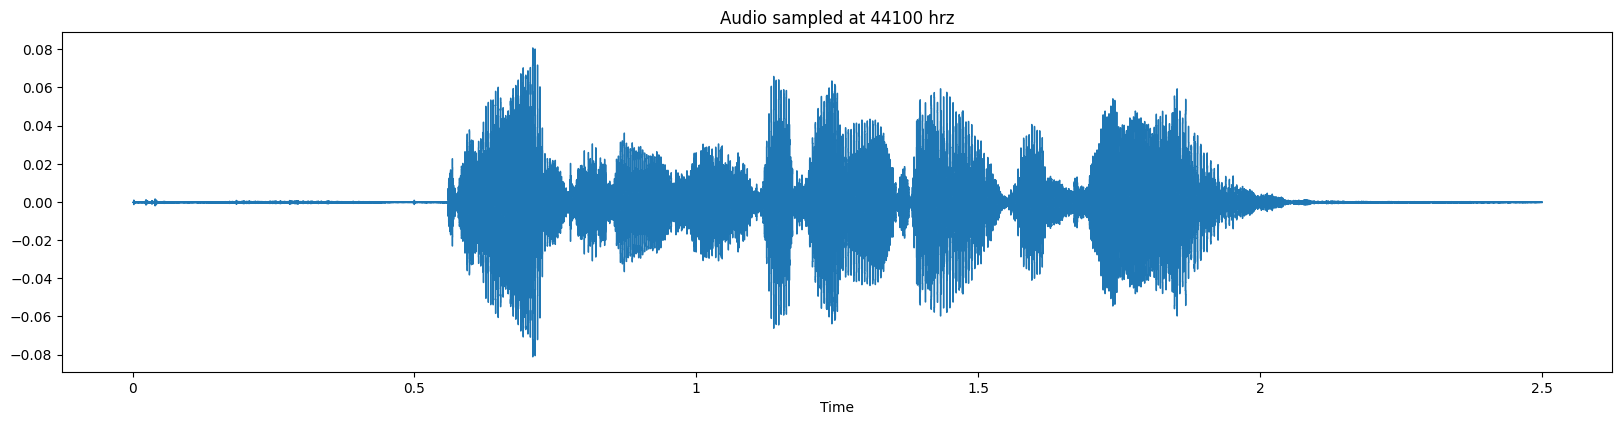

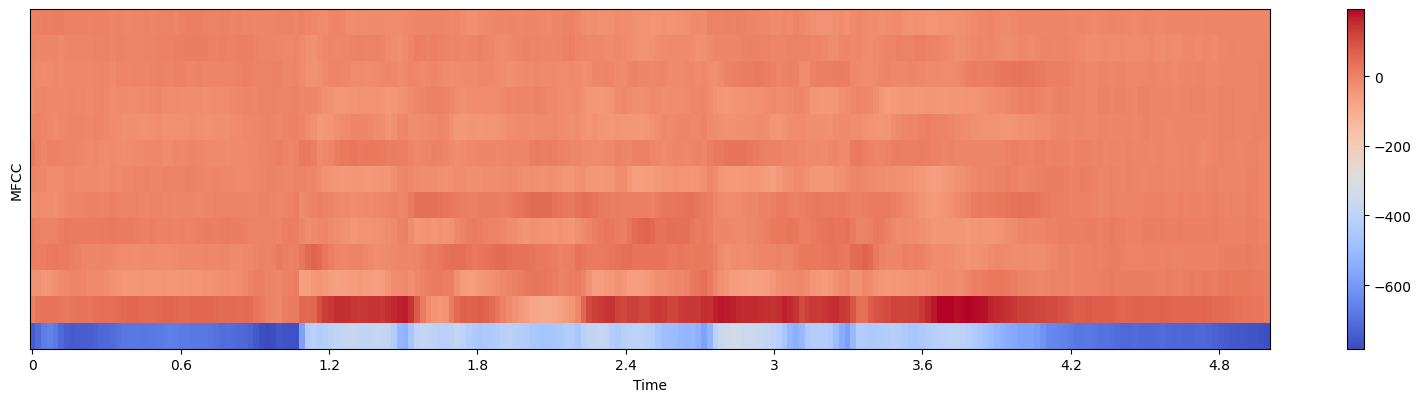

In [ ]:
# Source - RAVDESS; Gender - Female; Emotion - Happy
path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_12/03-01-03-01-02-01-12.wav"
X, sample_rate = librosa.load(path,duration=2.5,sr=22050*2,offset=0.5)
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

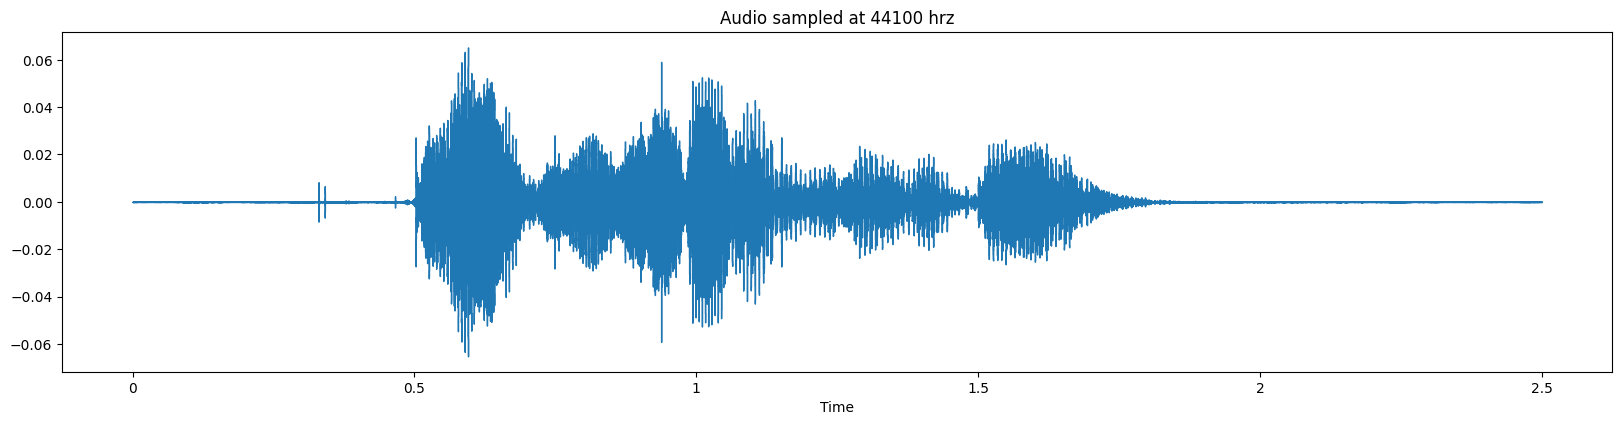

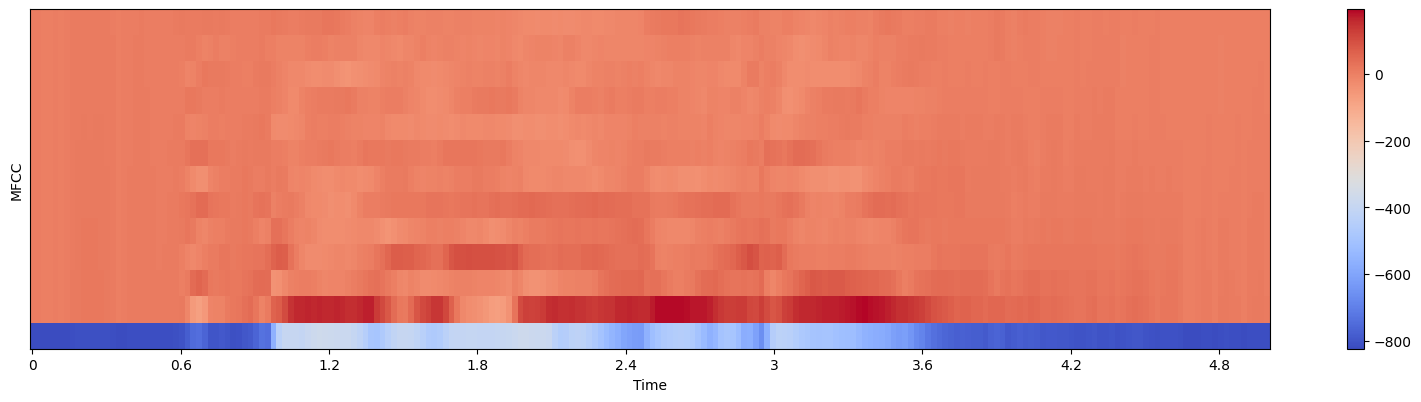

In [ ]:
# Source - RAVDESS; Gender - Male; Emotion - Happy
path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_11/03-01-03-01-02-02-11.wav"
X, sample_rate = librosa.load(path, duration=2.5,sr=22050*2,offset=0.5)
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

<a id="stats"></a>
## 3. Statistical features
Now we've seen the shape of an MFCC output for each file, and it's a 2D matrix format with MFCC bands on the y-axis and time on the x-axis, representing the MFCC bands over time. To simplify things, what we're going to do is take the mean across each band over time. In other words, row means. But how does it present as a distinctive feature?

So if you look at the above MFCC plot, the first band at the bottom is the most distinctive band over the other bands. Since the time window is a short one, the changes observed overtime does not vary greatly. The key feature is capturing the information contained in the various bands. Lets plot the mean of each of the band and display it as a time series plot to illustrate the point.

We'll compare the Angry female and Angry male for the same sentence uttered.

216
216


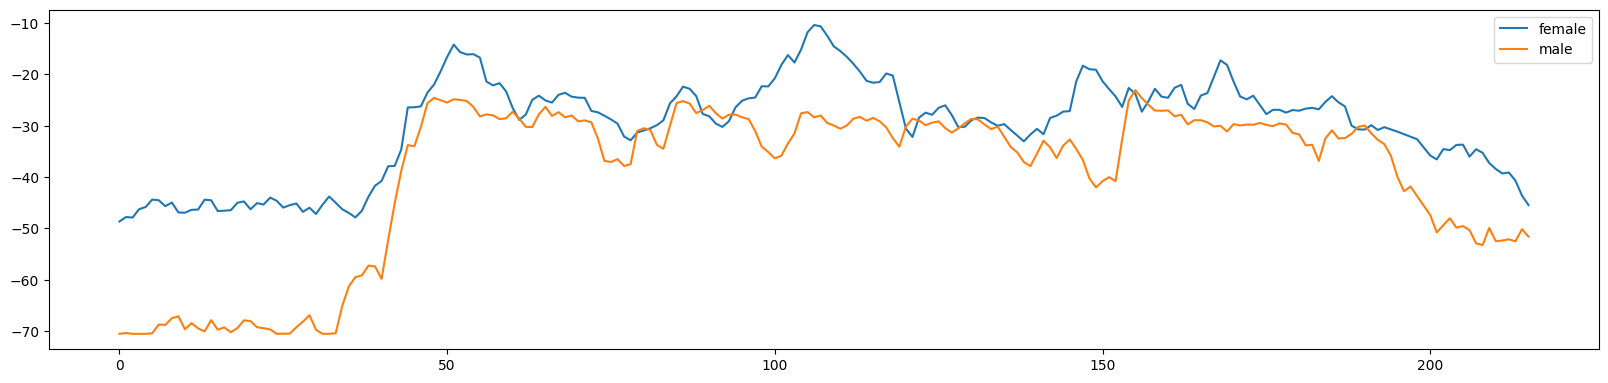

In [ ]:
# Source - RAVDESS; Gender - Female; Emotion - Angry
path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path,duration=2.5,sr=22050*2,offset=0.5)
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - Angry
path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path,duration=2.5,sr=22050*2,offset=0.5)
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

What do you notice in the comparison above? Are the female and male voices equivalent?
Try some other pairs, and compare the same gender but different emotions.

<a id="final"></a>
## 4. Final thoughts
Even thou we've ommited alot of good information by just taking the mean, it seems we still capture enough to be able to see some difference. Whether this difference is significant for distinguishing the various emotions, we'll find out in the next part where we will create a baseline emotion classifier.

# <center>Audio Emotion Recognition</center>
## <center>Part 3 - Baseline model</center>
#### <center> 24th August 2019 </center>
#####  <center> Eu Jin Lok </center>

## Introduction
Continuing on, we'll build a baseline (i.e., highly simple) model for an emotion classifier. View points will vary from one data scientist to another, but essentially its a model __NOT__ meant to achieve full accuracy potential. It's just to quickly test the framework and setup the blueprint for how we go about creating a workable emotion classifier, cause at the moment, we don't know what works and what doesn't.

In [ ]:
# Importing required libraries
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
#from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook
import resampy

In [ ]:
print(keras.__version__)

3.10.0


<a id="data"></a>
## 1. Data preparation and processing
We saw in [Part 1](https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-1-explore-data) and [Part 2](https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-2-feature-extra) the way we process the audio file into data and the MFCC features we extracted. We're going to do the same thing here except we process the entirity of the audio files. First up we need the reference file that contains the path to the raw audio files for training.

<a id="preparation"></a>
### Data preparation
Lets pick up the meta-data file which we save in [part 1]("https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-1-explore-data"), we're going to need it here to run a loop over it to read all the audio files spread across the 4 directories.

In [ ]:
# lets pick up the meta-data that we got from our first part of the Kernel
ref = pd.read_csv("./Data_path.csv")
ref.head()

labels   source                                               path
0  male_neutral  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...
1  male_neutral  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...
2      male_sad  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...
3  male_neutral  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...
4  male_neutral  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...

So we've already seen the shape of an MFCC output for each file, and it's a 2D matrix of the number of bands by time. In order to optimise space and memory, we're going to read each audio file, extract its mean across all MFCC bands by time, and  just keep the extracted features, dropping the entire audio file data.

In [ ]:
# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets
df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  , duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)

    # mean as the feature. Could do min and max etc as well.
    mfccs = np.mean(librosa.feature.mfcc(y=X,
                                        sr=sample_rate,
                                        n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

1440


feature
0  [-69.05284, -69.05284, -69.05284, -69.05284, -...
1  [-63.19238, -62.80182, -63.83239, -60.554276, ...
2  [-62.10632, -62.10632, -62.10632, -62.039402, ...
3  [-73.256584, -73.256584, -73.256584, -73.25658...
4  [-69.69473, -69.69473, -69.69473, -69.69473, -...

<a id="processing"></a>
### Data processing

Like any good standard data science workflow, data processing is the most important step. Cause garbage in grabage out. So lets start munging the data into a workable format and pad out any issues we find.

In [ ]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

labels   source                                               path  \
0  male_neutral  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...   
1  male_neutral  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...   
2      male_sad  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...   
3  male_neutral  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...   
4  male_neutral  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...   

           0          1          2          3          4          5  \
0 -69.052841 -69.052841 -69.052841 -69.052841 -69.052841 -68.756660   
1 -63.192379 -62.801819 -63.832390 -60.554276 -60.823406 -62.075230   
2 -62.106319 -62.106319 -62.106319 -62.039402 -62.106319 -62.106319   
3 -73.256584 -73.256584 -73.256584 -73.256584 -68.776535 -69.382439   
4 -69.694733 -69.694733 -69.694733 -69.694733 -69.694733 -69.694733   

           6  ...        206        207        208        209        210  \
0 -69.052841  ... -59.826195 -57.683342 -56.302959 -58.651829 -63.882717   
1 -64.890999  ... -65.391655 -65.391655 -65.391655 -65.391655 -65.391655   
2 -62.106319  ... -57.710815 -60.359478 -61.091988 -62.028072 -61.806293   
3 -73.256584  ... -27.030857 -26.351856 -27.009645 -28.068186 -27.058327   
4 -69.694733  ... -61.968838 -61.020218 -60.342880 -63.467102 -64.501839   

         211        212        213        214        215  
0 -63.751205 -65.224091 -65.309860 -67.016991 -68.825333  
1 -65.391655 -65.391655 -65.391655 -65.391655 -65.391655  
2 -61.252811 -59.137211 -61.461342 -62.106319 -62.106319  
3 -27.183224 -27.286089 -26.616442 -24.923210 -23.645393  
4 -61.648342 -58.003067 -58.850143 -62.757710 -62.831581  

[5 rows x 219 columns]

In [ ]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(1440, 219)


labels   source                                               path  \
0  male_neutral  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...   
1  male_neutral  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...   
2      male_sad  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...   
3  male_neutral  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...   
4  male_neutral  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...   

           0          1          2          3          4          5  \
0 -69.052841 -69.052841 -69.052841 -69.052841 -69.052841 -68.756660   
1 -63.192379 -62.801819 -63.832390 -60.554276 -60.823406 -62.075230   
2 -62.106319 -62.106319 -62.106319 -62.039402 -62.106319 -62.106319   
3 -73.256584 -73.256584 -73.256584 -73.256584 -68.776535 -69.382439   
4 -69.694733 -69.694733 -69.694733 -69.694733 -69.694733 -69.694733   

           6  ...        206        207        208        209        210  \
0 -69.052841  ... -59.826195 -57.683342 -56.302959 -58.651829 -63.882717   
1 -64.890999  ... -65.391655 -65.391655 -65.391655 -65.391655 -65.391655   
2 -62.106319  ... -57.710815 -60.359478 -61.091988 -62.028072 -61.806293   
3 -73.256584  ... -27.030857 -26.351856 -27.009645 -28.068186 -27.058327   
4 -69.694733  ... -61.968838 -61.020218 -60.342880 -63.467102 -64.501839   

         211        212        213        214        215  
0 -63.751205 -65.224091 -65.309860 -67.016991 -68.825333  
1 -65.391655 -65.391655 -65.391655 -65.391655 -65.391655  
2 -61.252811 -59.137211 -61.461342 -62.106319 -62.106319  
3 -27.183224 -27.286089 -26.616442 -24.923210 -23.645393  
4 -61.648342 -58.003067 -58.850143 -62.757710 -62.831581  

[5 rows x 219 columns]

Now that looks alot better. Next step we will split the data into 2 parts, one for training and one for validation. This ensures we measure the model's performance at its true accuracy.

In [ ]:
# Split between train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation
X_train[150:160]

0          1          2          3          4          5    \
1050 -58.830585 -58.185959 -57.322998 -57.011135 -58.563541 -58.655010   
1089 -64.746361 -61.184517 -65.279648 -66.382988 -66.382988 -62.292385   
1272 -58.335793 -56.588867 -55.312004 -50.034325 -49.064915 -53.331841   
1029 -40.630974 -40.592106 -40.606724 -40.650314 -40.646809 -40.656071   
1336 -60.838066 -60.838066 -60.838066 -60.838066 -60.838066 -60.838066   
328  -42.755058 -42.355553 -42.241856 -42.021877 -40.182293 -41.092754   
318  -68.736061 -62.956467 -62.559895 -62.986244 -60.504417 -62.692173   
1108 -46.689236 -46.689236 -46.689236 -46.689236 -46.689236 -46.689236   
1176 -58.781792 -58.781792 -58.781792 -58.781792 -58.781792 -58.781792   
12   -67.737740 -67.776337 -66.747772 -65.959564 -67.737740 -67.737740   

            6          7          8          9    ...        206        207  \
1050 -58.142136 -58.826107 -58.951775 -57.580391  ... -42.677971 -41.664944   
1089 -60.420631 -64.683640 -61.490864 -55.493671  ... -38.894997 -39.033260   
1272 -53.828613 -54.382198 -55.633884 -56.334229  ... -55.805214 -55.856606   
1029 -40.657143 -40.646797 -40.633259 -40.653744  ... -38.338345 -37.959335   
1336 -60.838066 -60.838066 -60.838066 -60.838066  ... -43.291019 -47.383293   
328  -42.875156 -42.279385 -43.593838 -44.335228  ... -41.989258 -41.205296   
318  -67.729561 -61.824524 -61.321518 -65.901810  ... -45.404522 -44.790287   
1108 -46.689236 -46.689236 -46.689236 -46.689236  ... -22.367941 -22.512714   
1176 -58.781792 -58.781792 -58.781792 -58.781792  ... -53.179131 -53.422798   
12   -67.737740 -67.260529 -67.737740 -67.737740  ... -61.194679 -61.117886   

            208        209        210        211        212        213  \
1050 -44.037910 -46.628036 -47.148991 -47.804634 -50.206402 -54.678448   
1089 -39.599529 -41.534676 -42.885872 -44.232414 -45.495487 -43.347183   
1272 -57.657448 -58.335793 -58.335793 -58.335793 -57.919411 -55.109062   
1029 -37.453171 -39.120987 -39.736691 -40.299988 -40.658012 -40.658012   
1336 -48.056648 -47.481010 -49.160522 -47.871853 -48.231785 -49.630760   
328  -40.645634 -41.088047 -43.425041 -44.592049 -44.895195 -45.295284   
318  -44.549419 -45.499680 -44.627010 -43.825401 -43.077999 -42.538677   
1108 -22.393547 -24.326365 -25.314003 -22.861326 -21.901865 -19.742048   
1176 -53.156246 -55.453693 -56.331150 -55.670956 -56.556351 -55.603806   
12   -63.292915 -65.846077 -65.122780 -59.516930 -59.593105 -66.713745   

            214        215  
1050 -53.373909 -53.763325  
1089 -38.230373 -30.717720  
1272 -52.931187 -55.118931  
1029 -40.658012 -40.658012  
1336 -50.206142 -50.507915  
328  -44.890129 -44.388199  
318  -39.864784 -36.742832  
1108 -18.906681 -13.917532  
1176 -55.451298 -56.987583  
12   -67.737740 -67.737740  

[10 rows x 216 columns]

We also get a list of the correct emotion labels, which we'll use later.

In [ ]:
y_test[150:160]

163        male_neutral
925         female_fear
1151     female_disgust
638        male_neutral
799        female_angry
481           male_fear
938     female_surprise
261        male_neutral
538       male_surprise
218      female_disgust
Name: labels, dtype: object

Now because we are mixing up a few different data sources, it would be wise to normalise the data. This is proven to improve the accuracy and speed up the training process. Prior to the discovery of this solution in the embrionic years of neural network, the problem used to be know as "exploding gradients".

In [ ]:
# Lts do data normalization
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now
X_train[150:160]

0         1         2         3         4         5         6    \
1050 -0.301111 -0.294483 -0.186185 -0.144516 -0.328419 -0.347119 -0.288701   
1089 -0.982880 -0.643074 -1.129408 -1.252754 -1.247381 -0.773516 -0.553371   
1272 -0.244088 -0.108817  0.052209  0.680504  0.787886  0.276898  0.212358   
1029  1.796320  1.750847  1.795450  1.790179  1.777205  1.762835  1.742358   
1336 -0.532465 -0.602798 -0.602880 -0.597057 -0.595727 -0.603031 -0.601860   
328   1.551528  1.545842  1.601613  1.627989  1.831796  1.711644  1.484713   
318  -1.442677 -0.849067 -0.806995 -0.851083 -0.556516 -0.820382 -1.402377   
1108  1.098130  1.042040  1.074397  1.076066  1.067083  1.055588  1.041669   
1176 -0.295488 -0.363751 -0.359118 -0.353899 -0.354068 -0.361981 -0.363003   
12   -1.327625 -1.409390 -1.303448 -1.202683 -1.406596 -1.411856 -1.403327   

           7         8         9    ...       206       207       208  \
1050 -0.366033 -0.391330 -0.237748  ...  0.268965  0.375489  0.192638   
1089 -1.046116 -0.688151  0.006422  ...  0.592583  0.599983  0.571279   
1272  0.149923 -0.003468 -0.091933  ... -0.854016 -0.835122 -0.969253   
1029  1.744659  1.750110  1.742863  ...  0.640203  0.691594  0.754386   
1336 -0.599629 -0.611839 -0.618933  ...  0.216522 -0.112312 -0.150203   
328   1.555109  1.404017  1.312087  ...  0.327882  0.414699  0.482035   
318  -0.714161 -0.668354 -1.211449  ...  0.035720  0.108883  0.149001   
1108  1.043107  1.042164  1.036641  ...  2.006405  2.009258  2.039132   
1176 -0.360887 -0.371459 -0.378326  ... -0.629365 -0.627508 -0.585253   
12   -1.345303 -1.418412 -1.426274  ... -1.315063 -1.283933 -1.450019   

           209       210       211       212       213       214       215  
1050 -0.001604 -0.030199 -0.070632 -0.250741 -0.611493 -0.502496 -0.496393  
1089  0.436810  0.336844  0.237813  0.154983  0.362976  0.700746  1.140725  
1272 -1.009358 -0.993353 -0.979949 -0.915019 -0.648526 -0.467319 -0.592692  
1029  0.644570  0.607980  0.577359  0.571608  0.594240  0.507856  0.434585  
1336 -0.075025 -0.203387 -0.076436 -0.080679 -0.177401 -0.250798 -0.265134  
328   0.475254  0.290423  0.206760  0.206683  0.195442  0.171590  0.169599  
318   0.095520  0.186937  0.272956  0.363188  0.432506  0.570883  0.712712  
1108  1.918029  1.849735  2.083107  2.186968  2.392976  2.236126  2.334179  
1176 -0.761279 -0.820759 -0.749853 -0.797626 -0.691073 -0.667556 -0.725438  
12   -1.655811 -1.577694 -1.081935 -1.059165 -1.646508 -1.643786 -1.489109  

[10 rows x 216 columns]



Next part we'll need to convert the data format to a numpy array, because we are using keras.

In [ ]:
# Lets few preparation steps to get it into the correct format for Keras
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train)) # this convers the list of labels to a list of vectors
y_test = to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(1080, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


-------------------
Now because we are using a CNN, we need to specify the 3rd dimension, which for us is 1. Its 1 because we're doing a 1D CNN and not a 2D CNN. If we use the MFCC data in its entirity, we could feed that through as the input data, thus making the network a 2D CNN.  

In [ ]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(1080, 216, 1)

<a id="modelling"></a>
## 2. Modelling
The architecture of the model below is based on a few sources that I've seen before such as Kaggle and Stackoverflow. I'm unable to find the source but safe to say this particular format works quite well and is fast, although I've used GPU.

In [ ]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_64 (Conv1D)              │ (None, 216, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_72 (Activation)      │ (None, 216, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_65 (Conv1D)              │ (None, 216, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 216, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_73 (Activation)      │ (None, 216, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 216, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_66 (Conv1D)              │ (None, 27, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_74 (Activation)      │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_67 (Conv1D)              │ (None, 27, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_75 (Activation)      │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_68 (Conv1D)              │ (None, 27, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_76 (Activation)      │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_69 (Conv1D)              │ (None, 27, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 27, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_77 (Activation)      │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_70 (Conv1D)              │ (None, 3, 64)          │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_78 (Activation)      │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_71 (Conv1D)              │ (None, 3, 64)          │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_79 (Activation)      │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 14)             │         2,70

 Total params: 1,285,390 (4.90 MB)

 Trainable params: 1,284,622 (4.90 MB)

 Non-trainable params: 768 (3.00 KB)

Great! We have a summary. What does this actually tell us about the model architecture though? There are a few key details you'll want to look at. <br><br>
Note the Output Shape column. The second value is the sequence length. Basically, it's the number of time-points in the audio file for which the model will operate on. Notice that at each <i>pooling</i> layer, the number goes down. This is because we first want to extract features at many time points, then combine them into higher-level abstractions, before arriving at a more condensed representation in the deepest layers. (Look at LC2 question 2) <br><br>
We also see how many total parameters there are in the model. The trainable parameters are the ones that are <i>updated</i> during training. Non-trainable parameters are frozen, and help stabilize the model. <br><br>
We also see the logic of the model. This is of course the same as what is provided in the code block above, but this can also be useful if you are working with a pretrained model, and for generating an easy-to-read summary. For example, here we see several types of layers, so we can easily see how the model works:
- convolution
- activation
- dropout
- pooling


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 286ms/step - accuracy: 0.1000 - loss: 2.6744 - val_accuracy: 0.0528 - val_loss: 2.6368
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - accuracy: 0.2044 - loss: 2.4574 - val_accuracy: 0.0528 - val_loss: 2.6341
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 261ms/step - accuracy: 0.2498 - loss: 2.3444 - val_accuracy: 0.0500 - val_loss: 2.6289
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 268ms/step - accuracy: 0.3216 - loss: 2.2617 - val_accuracy: 0.0667 - val_loss: 2.6179
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 273ms/step - accuracy: 0.3188 - loss: 2.1949 - val_accuracy: 0.1333 - val_loss: 2.5945
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 262ms/step - accuracy: 0.2918 - loss: 2.1798 - val_accuracy: 0.1917 - val_loss: 2.5547
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 269ms/step - accuracy: 0.3273 - loss: 2.1025 - val_accuracy: 0.2056 - val_loss: 2.4897
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 278ms/step - accuracy: 0.3650 - loss: 2.0328 - 

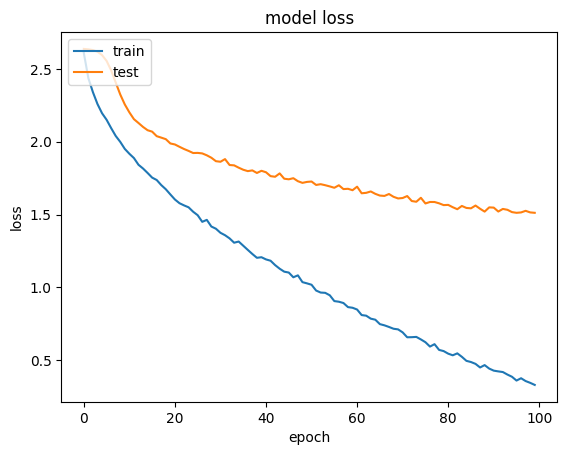

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

So we can see that the loss starts to plateau now at around 50 epochs. Regardless we'll keep it at 100 as the final model.

<a id="serialise"></a>
## 3. Model serialisation
So its time to serialise the model for re-usability. Serialisation and saving mean the same thing. We need to serialise the model architecture and the weights, thats all.

In [ ]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/saved_models/Emotion_Model.h5 


<a id="validation"></a>
## 4. Model validation
Now predicting emotions on the test data. After serialising the model above, i'm going to just reload it into disk. Essentially to re-use the model without having to retrain by re-running the code, we just need to run this section of the code and apply the model to a new dataset. Since we used the same test set in the keras model, the result is essentially the same as the last epoch of 100 which is 43.80%

In [ ]:
# loading json and model architecture
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")

# Keras optimiser
opt = keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
compile_metrics: 50.28%


In [ ]:
preds = loaded_model.predict(X_test,
                         batch_size=16,
                         verbose=1)

preds=preds.argmax(axis=1)
preds

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


array([10, 13,  4,  2, 10,  8,  4,  4,  5, 11,  9,  5,  7,  2,  0,  1,  4,
        9,  4,  4,  0,  2,  5, 11,  0, 10, 10,  4, 13, 13, 10, 10, 10,  7,
        7,  7, 11,  7,  6,  1,  9,  0,  1, 12, 11,  8,  4, 10,  3,  6, 13,
        2, 11,  4,  4,  1,  4,  4,  7, 10, 11,  0,  7,  6,  5,  2,  4,  8,
        4, 11,  6,  4,  6,  5, 10, 10,  8,  0, 12,  0, 12,  5,  1,  0,  4,
       10,  5,  1,  7, 10,  0,  1,  6, 10,  1,  5, 11,  7,  4,  7,  5,  9,
       10, 11, 10,  5,  6,  6,  9, 10,  0,  4,  4, 11,  6,  3, 11, 10,  9,
       13,  6,  4,  2, 10, 11, 11,  9,  1,  1,  1, 11, 10, 10, 11,  6, 11,
        4, 11,  4,  1,  7,  3,  1, 11, 10, 13,  5,  7, 12,  4, 10,  2,  4,
       12,  3, 10,  6, 11, 11,  1, 10,  4,  3,  5,  1,  5, 10,  0,  4,  4,
        1, 10,  4,  3,  9,  0, 10, 10,  8,  5,  4,  5,  1,  4,  4, 11,  6,
        4,  0,  5, 11,  1,  4,  4, 11,  4, 10,  3,  5,  3,  0, 12, 10,  6,
        7,  0, 11,  2, 11, 10,  6, 11,  1,  1,  5, 11,  5,  1,  4, 10,  3,
       10,  3,  6, 12,  5

The prediction is in the form of numbers, we'll need to append the labels to it before we run the accuracy measure...

In [ ]:
# predictions
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

actualvalues predictedvalues
170  female_surprise  female_disgust
171       male_happy      male_happy
172     female_happy  female_neutral
173      female_fear    female_happy
174    male_surprise       male_fear
175     female_angry    female_angry
176       male_happy      male_happy
177       male_angry      male_happy
178     male_disgust    male_disgust
179       female_sad      female_sad

Lets write the predictions out into a file for re-use

In [ ]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

actualvalues
predictedvalues              
female_angry               26
female_disgust             30
female_fear                14
female_happy               17
female_neutral             59
female_sad                 26
female_surprise            26
male_angry                 21
male_disgust               10
male_fear                  13
male_happy                 59
male_neutral               36
male_sad                   12
male_surprise              11

So, we've made our predictions, so how well have we done? We're going to use the most simplest form of accuracy measure which is absolute accuracy, which is really just the % of records where Actual = Predicted, over the total number of records predicted. We'll also produce the F1, recall and precision scores.

The most common way to visualise this output is via a confusion matrix. I found an excellent heat map plot to visualise the accuracy of the confusion matrix [here](https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823) which i've borrowed for this notebook

In [ ]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'


#### Emotion by gender accuracy  
So lets visualise how well we have done for the Emotion by Gender model

0.5027777777777778


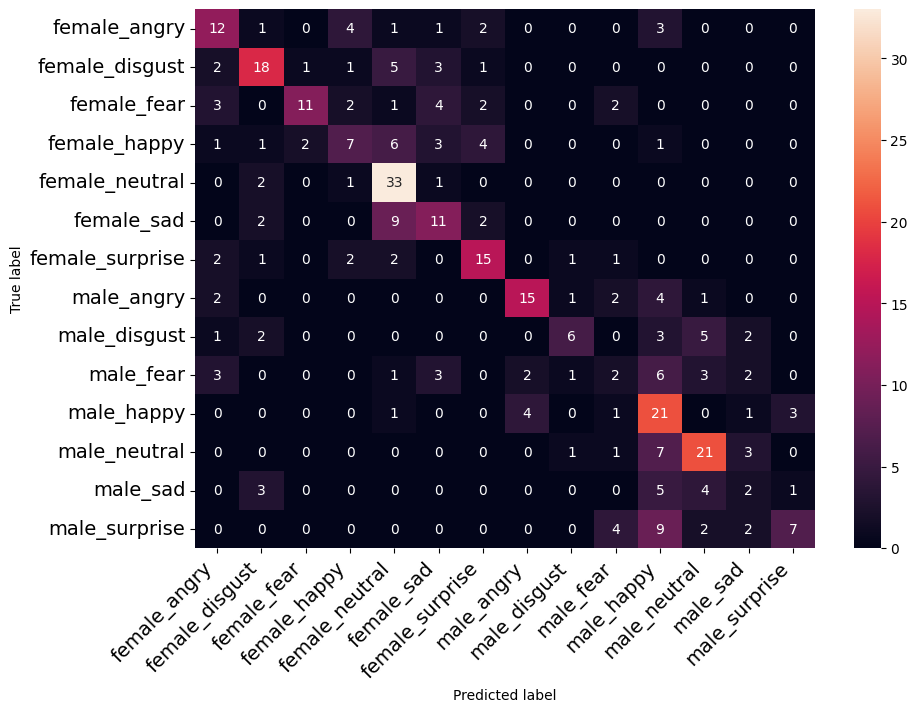

In [ ]:
# Get the predictions file
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()

# Confusion matrix
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [ ]:
# Classification report
classes = finaldf.actualvalues.unique()
classes.sort()
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.46      0.50      0.48        24
 female_disgust       0.60      0.58      0.59        31
    female_fear       0.79      0.44      0.56        25
   female_happy       0.41      0.28      0.33        25
 female_neutral       0.56      0.89      0.69        37
     female_sad       0.42      0.46      0.44        24
female_surprise       0.58      0.62      0.60        24
     male_angry       0.71      0.60      0.65        25
   male_disgust       0.60      0.32      0.41        19
      male_fear       0.15      0.09      0.11        23
     male_happy       0.36      0.68      0.47        31
   male_neutral       0.58      0.64      0.61        33
       male_sad       0.17      0.13      0.15        15
  male_surprise       0.64      0.29      0.40        24

       accuracy                           0.50       360
      macro avg       0.50      0.47      0.46       360
   weighted avg       0.51   

What is the absolute accuracy for the gender by emotions? Is this good or bad?

---------------
#### Gender accuracy result
if you notice, that the gender-specific classification is more accurate. So lets group them up and measure the accuracy again?

0.9333333333333333


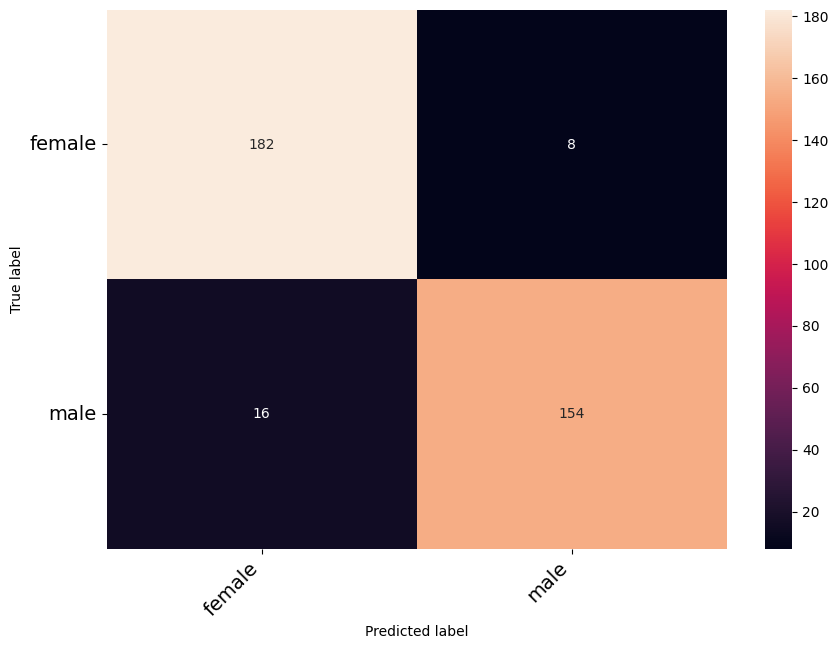

In [ ]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()
classes.sort()

# Confusion matrix
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [ ]:
# Classification report
classes = modidf.actualvalues.unique()
classes.sort()
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.92      0.96      0.94       190
        male       0.95      0.91      0.93       170

    accuracy                           0.93       360
   macro avg       0.93      0.93      0.93       360
weighted avg       0.93      0.93      0.93       360



What do you see here? Is accuracy similar between genders?

#### Emotion accuracy
We'll now ignore the gender part and just super group them into the 7 core emotions. Lets see what we get...

0.5222222222222223


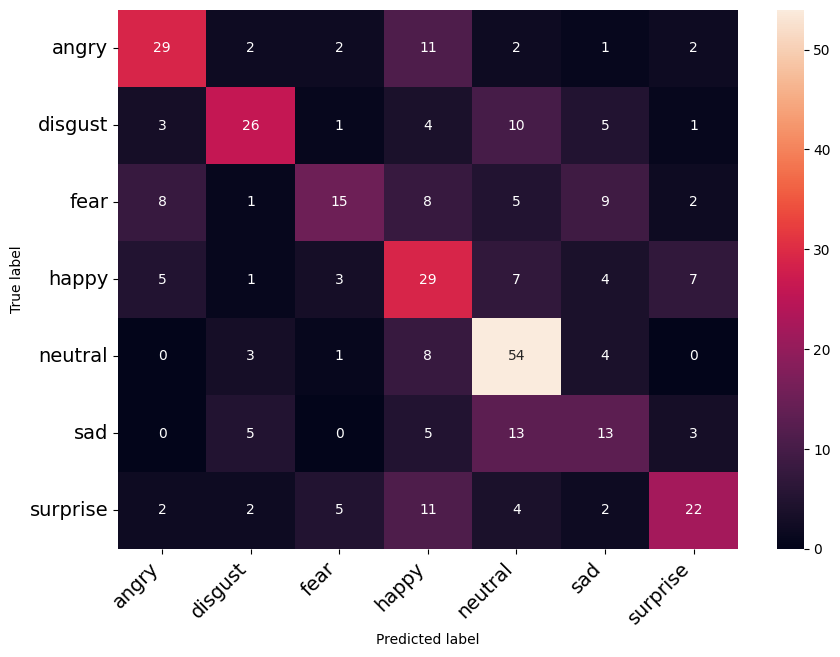

In [ ]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique()
classes.sort()

# Confusion matrix
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [ ]:
# Classification report
classes = modidf.actualvalues.unique()
classes.sort()
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.62      0.59      0.60        49
     disgust       0.65      0.52      0.58        50
        fear       0.56      0.31      0.40        48
       happy       0.38      0.52      0.44        56
     neutral       0.57      0.77      0.65        70
         sad       0.34      0.33      0.34        39
    surprise       0.59      0.46      0.52        48

    accuracy                           0.52       360
   macro avg       0.53      0.50      0.50       360
weighted avg       0.53      0.52      0.52       360



50%, not too shabby indeed. The precision and recall for 'Surprise' and 'Angry' is pretty good in particular

<a id="final"></a>
## 5. Final thoughts
The gender seperation turns out to be a curcial implementation in order to accurately classify emotions.

If you want to continue with these models, there are also notebookes available for checking for generalisability of this initial baseline solution before  before implementing further enhancements, followed by an audio streamer that will give us the capability of predicting the emotions of a segment of the audio call.  See here: https://www.kaggle.com/code/ejlok1/audio-emotion-part-4-apply-to-new-audio-data

This section of the notebook borrowed heavily from this [repository](https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer). The original author may have overstated the accuracy as I wasn't able to replicate the accuracy results but, by in large the approach is pretty sound and I've taken his work as a blueprint to setup my own here.